In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    bstype = torch.float
    buftype = torch.float
    randtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias, 
                              bstype=bstype, buftype=buftype, randtype=randtype).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, randtype=randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, bstype=bstype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.8489992618560791 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010163811035454273 max: -0.0010715946555137634 RMSE:  0.006072476971894503
error distribution=========>


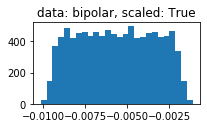

progressive accuracy=========>


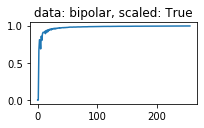

--- 0.8470025062561035 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.350006103515625 max: 0.109375 RMSE:  0.318521648645401
error distribution=========>


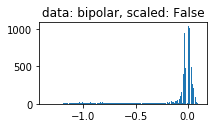

progressive accuracy=========>


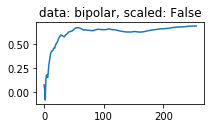

--- 0.5740001201629639 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005618572235107422 max: -0.0012637972831726074 RMSE:  0.0036869163159281015
error distribution=========>


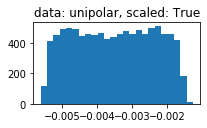

progressive accuracy=========>


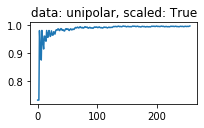

--- 0.5350000858306885 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


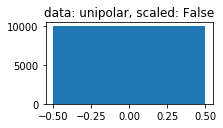

progressive accuracy=========>


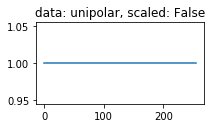

In [5]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8149983882904053 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.010483769699931145 max: -0.0012689483119174838 RMSE:  0.006281150504946709
error distribution=========>


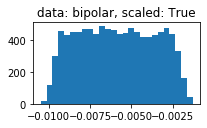

progressive accuracy=========>


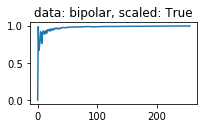

--- 0.8350002765655518 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -1.3572845458984375 max: 0.2421875 RMSE:  0.3280094265937805
error distribution=========>


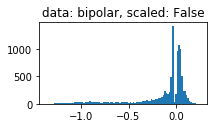

progressive accuracy=========>


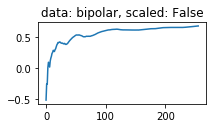

--- 0.5290002822875977 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.006421416997909546 max: -0.0021418333053588867 RMSE:  0.004445895552635193
error distribution=========>


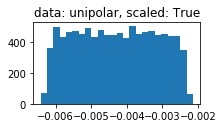

progressive accuracy=========>


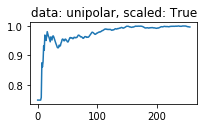

--- 0.5300004482269287 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


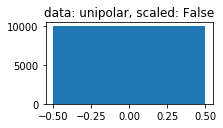

progressive accuracy=========>


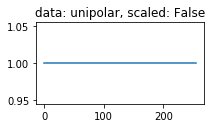

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.7380006313323975 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010401081293821335 max: -0.0012889958452433348 RMSE:  0.006365359760820866
error distribution=========>


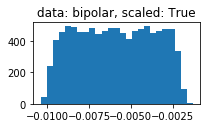

progressive accuracy=========>


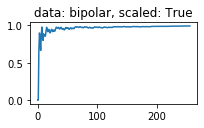

--- 0.730999231338501 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.9140625 max: 1.6484375 RMSE:  0.552423357963562
error distribution=========>


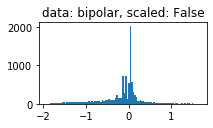

progressive accuracy=========>


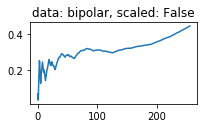

--- 0.5020020008087158 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.0054929256439208984 max: -0.001160740852355957 RMSE:  0.003511307528242469
error distribution=========>


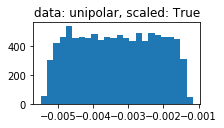

progressive accuracy=========>


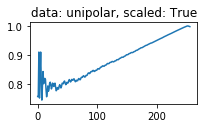

--- 0.49700093269348145 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


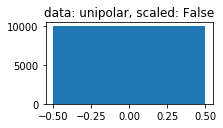

progressive accuracy=========>


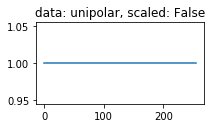

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8229997158050537 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010249147191643715 max: -0.0012947656214237213 RMSE:  0.006118872202932835
error distribution=========>


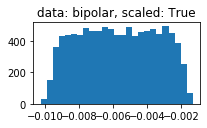

progressive accuracy=========>


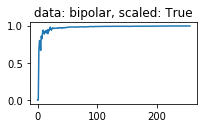

--- 0.8290011882781982 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.32647705078125 max: 0.4437408447265625 RMSE:  0.33404380083084106
error distribution=========>


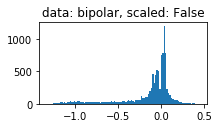

progressive accuracy=========>


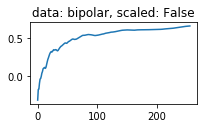

--- 0.5329999923706055 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005539238452911377 max: -0.0011819303035736084 RMSE:  0.003523879684507847
error distribution=========>


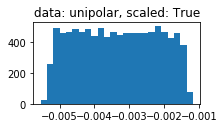

progressive accuracy=========>


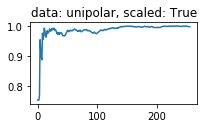

--- 0.5329999923706055 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


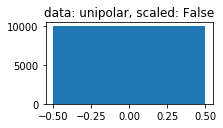

progressive accuracy=========>


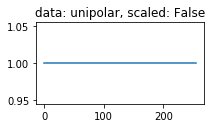

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)